In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import gc 

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.transforms as transforms
from torchvision import models 
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn.model_selection import train_test_split

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../"))

['AirbusShipDetection-MaskRCNN', 'AirbusShipDetection-pix2pix', 'AirbusShipDetection-Unet', 'test', 'tmp', 'train', 'train_ship_segmentations.csv']


In [2]:
%matplotlib inline 

In [3]:
masks = pd.read_csv('../train_ship_segmentations.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [4]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    #nan check
    if mask_rle != mask_rle:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


"""
 trainの画像の教師画像を作る
"""
def create_mask(image_path):
    img_masks = masks.loc[masks['ImageId'] == image_path.split('/')[-1], 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    masks_all = np.zeros((768, 768))
    for mask in img_masks:
        masks_all += rle_decode(mask)
    masks_all = np.minimum(masks_all, 1)*255
    tmp = np.array((masks_all, masks_all, masks_all), dtype=np.uint8)
    tmp = tmp.transpose(1,2,0)
    
    return tmp

"""
白黒画像をランレングス記法にする
"""
def convert_runlength(convert_image):
    convert_image = cv2.resize(convert_image, (768, 768))
    flatten = np.where((convert_image.T).flatten() == 1)[0]
    runlength = ""
    count = 0
    if len(flatten) == 1:
        runlength = str(flatten[0]) + " 1"
        return runlength
    for i in range(len(flatten)):
        if i == 0:
            runlength = runlength +  str(flatten[i]) + " "
            count = 1
        elif i == len(flatten)-1:
            if flatten[i] == flatten[i-1]+1:
                count += 1
                runlength = runlength + str(count)
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " 1"
        else:
            if flatten[i] == flatten[i-1]+1:
                count += 1
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " "
                count = 1
    return runlength

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768,768), dtype=np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask) 
    return np.expand_dims(all_masks, -1) 

def mask_overlay(image, mask, color=(0, 1, 0)):
    mask = np.dstack((mask, mask, mask)) * np.array(color) 
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.) 
    img = image.copy() 
    ind = mask[:,:,1] > 0 
    img[ind] = weighted_sum[ind] 
    return img 

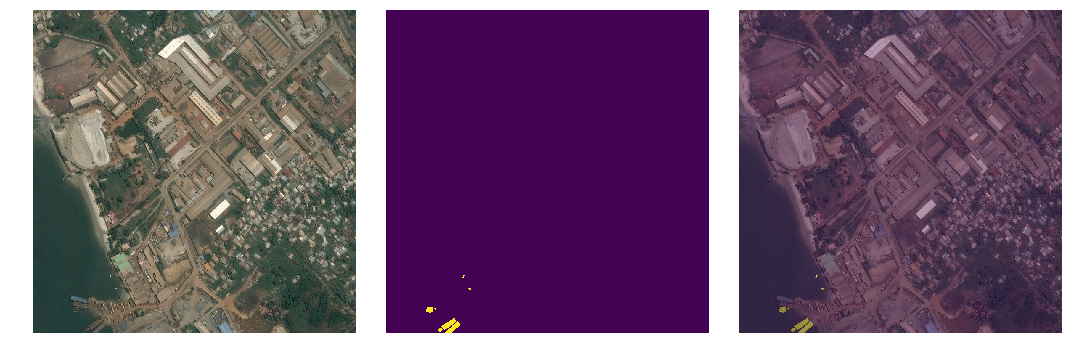

In [5]:
ImageId = '00021ddc3.jpg'

img = cv2.imread('../train/' + ImageId)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)
    
all_masks = np.minimum(all_masks, 1)
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [6]:
train_image_dir = "../train/"
test_image_dir = "../test/"
# これは1つ1つのデータを渡していくもの
class ShipDataset(Dataset):
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)
        img = cv2.imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
       
        if self.transform is not None:
            img, mask = self.transform(img, mask)
        tmp = self.img_transform(img) 
        #type(tmp) = <class 'torch.FloatTensor'>
        # tmp.shape = torch.Size([3, 256, 256])
        #tmp -= tmp.mean(dim=1, keepdim=True).mean(dim=2,keepdim=True)
        #tmp /= tmp.view(3,-1).std(dim=1,keepdim=True).view(3,1,1)
    
        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return tmp, torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return tmp, str(img_file_name)

class AirbusDataset(Dataset):
    def __init__(self, in_df,transform=None, root_dir=None):
        self.image_paths = in_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = (image-np.mean(img, axis=(1,2),keepdim=True))/ np.std(img, axis=(1,2),keepdim=True)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masked_img = create_mask(image_path)
        if self.transform:
            image, masked_img = self.transform(image, masked_img)
        return image, masked_img

In [7]:

def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask=None):
        for t in self.transforms:
            x, mask = t(x, mask)
        return x, mask
    
class OneOf:
    def __init__(self, transforms, prob=0.5):
        self.transforms = transforms
        self.prob = prob

    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            t = random.choice(self.transforms)
            t.prob = 1.
            x, mask = t(x, mask)
        return x, mask

class OneOrOther:
    def __init__(self, first, second, prob=0.5):
        self.first = first
        first.prob = 1.
        self.second = second
        second.prob = 1.
        self.prob = prob

    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            x, mask = self.first(x, mask)
        else:
            x, mask = self.second(x, mask)
        return x, mask


class ImageOnly:
    def __init__(self, trans):
        self.trans = trans

    def __call__(self, x, mask=None):
        return self.trans(x), mask


class VerticalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 0)
            if mask is not None:
                mask = cv2.flip(mask, 0)
        return img, mask


class HorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 1)
            if mask is not None:
                mask = cv2.flip(mask, 1)
        return img, mask


class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            img = cv2.flip(img, d)
            if mask is not None:
                mask = cv2.flip(mask, d)
        return img, mask


class Transpose:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = img.transpose(1, 0, 2)
            if mask is not None:
                mask = mask.transpose(1, 0, 2)
        return img, mask


class RandomRotate90:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            factor = random.randint(0, 4)
            img = np.rot90(img, factor)
            if mask is not None:
                mask = np.rot90(mask, factor)
        return img.copy(), mask.copy()


class Rotate:
    def __init__(self, limit=90, prob=0.5):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return img, mask


class RandomCrop:
    def __init__(self, size):
        self.h = size[0]
        self.w = size[1]

    def __call__(self, img, mask=None):
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self.h)
        w_start = np.random.randint(0, width - self.w)

        img = img[h_start: h_start + self.h, w_start: w_start + self.w,:]

        assert img.shape[0] == self.h
        assert img.shape[1] == self.w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self.h, w_start: w_start + self.w,:]

        return img, mask


class Shift:
    def __init__(self, limit=4, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            limit = self.limit
            dx = round(random.uniform(-limit, limit))
            dy = round(random.uniform(-limit, limit))

            height, width, channel = img.shape
            y1 = limit + 1 + dy
            y2 = y1 + height
            x1 = limit + 1 + dx
            x2 = x1 + width

            img1 = cv2.copyMakeBorder(img, limit + 1, limit + 1, limit + 1, limit + 1,
                                      borderType=cv2.BORDER_REFLECT_101)
            img = img1[y1:y2, x1:x2, :]
            if mask is not None:
                msk1 = cv2.copyMakeBorder(mask, limit + 1, limit + 1, limit + 1, limit + 1,
                                          borderType=cv2.BORDER_REFLECT_101)
                mask = msk1[y1:y2, x1:x2, :]

        return img, mask


class ShiftScale:
    def __init__(self, limit=4, prob=.25):
        self.limit = limit
        self.prob = prob

    def __call__(self, img, mask=None):
        limit = self.limit
        if random.random() < self.prob:
            height, width, channel = img.shape
            assert (width == height)
            size0 = width
            size1 = width + 2 * limit
            size = round(random.uniform(size0, size1))

            dx = round(random.uniform(0, size1 - size))
            dy = round(random.uniform(0, size1 - size))

            y1 = dy
            y2 = y1 + size
            x1 = dx
            x2 = x1 + size

            img1 = cv2.copyMakeBorder(img, limit, limit, limit, limit, borderType=cv2.BORDER_REFLECT_101)
            img = (img1[y1:y2, x1:x2, :] if size == size0
            else cv2.resize(img1[y1:y2, x1:x2, :], (size0, size0), interpolation=cv2.INTER_LINEAR))

            if mask is not None:
                msk1 = cv2.copyMakeBorder(mask, limit, limit, limit, limit, borderType=cv2.BORDER_REFLECT_101)
                mask = (msk1[y1:y2, x1:x2, :] if size == size0
                else cv2.resize(msk1[y1:y2, x1:x2, :], (size0, size0), interpolation=cv2.INTER_LINEAR))

        return img, mask


class ShiftScaleRotate:
    def __init__(self, shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, prob=0.5):
        self.shift_limit = shift_limit
        self.scale_limit = scale_limit
        self.rotate_limit = rotate_limit
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            height, width, channel = img.shape

            angle = random.uniform(-self.rotate_limit, self.rotate_limit)
            scale = random.uniform(1 - self.scale_limit, 1 + self.scale_limit)
            dx = round(random.uniform(-self.shift_limit, self.shift_limit)) * width
            dy = round(random.uniform(-self.shift_limit, self.shift_limit)) * height

            cc = math.cos(angle / 180 * math.pi) * scale
            ss = math.sin(angle / 180 * math.pi) * scale
            rotate_matrix = np.array([[cc, -ss], [ss, cc]])

            box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
            box1 = box0 - np.array([width / 2, height / 2])
            box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

            box0 = box0.astype(np.float32)
            box1 = box1.astype(np.float32)
            mat = cv2.getPerspectiveTransform(box0, box1)
            img = cv2.warpPerspective(img, mat, (width, height),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpPerspective(mask, mat, (width, height),
                                           flags=cv2.INTER_NEAREST,
                                           borderMode=cv2.BORDER_REFLECT_101)

        return img, mask


class CenterCrop:
    def __init__(self, size):
        self.height = size[0]
        self.width = size[1]

    def __call__(self, img, mask=None):
        h, w, c = img.shape
        dy = (h - self.height) // 2
        dx = (w - self.width) // 2
        y1 = dy
        y2 = y1 + self.height
        x1 = dx
        x2 = x1 + self.width
        img = img[y1:y2, x1:x2,:]
        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[y1:y2, x1:x2,:]

        return img, mask
    
class RandomBrightness:
    def __init__(self, limit=0.1, prob=0.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[..., :3] = clip(alpha * img[..., :3], dtype, maxval)
        return img


class RandomContrast:
    def __init__(self, limit=.1, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[:, :, :3] = clip(alpha * img[:, :, :3] + gray, dtype, maxval)
        return img

In [8]:
BATCH_SIZE = 40 # 次は40でもいけそう
img_size = 256 
DROP = 0.2

In [9]:
train_transform = DualCompose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomCrop((256,256,3)),
        #ImageOnly(RandomBrightness()),
        #ImageOnly(RandomContrast()),
])
"""
val_transform = DualCompose([
        CenterCrop((512,512,3)),
     ])
"""
#train_dataset = AirbusDataset(root_dir='../train/', transform=train_transform)
#train_batch = data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
#                            shuffle=True, num_workers=0)

'\nval_transform = DualCompose([\n        CenterCrop((512,512,3)),\n     ])\n'

In [10]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model    


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        conv_block(out_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [11]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        self.out = nn.Tanh()
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = nn.Dropout(p=DROP)(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        x = self.out(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [13]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [14]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss

In [15]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [16]:
def make_model():    
    resnet34 = models.resnet34(pretrained=True)
    for param in resnet34.parameters():
        param.requires_grad = False 
    resnet34 = nn.Sequential(*list(resnet34.children())[:-2])
    m = Unet34(resnet34)
    print(m.eval())
    return m 

In [17]:
m = make_model()

In [18]:
def make_loader(in_df, batch_size, shuffle=False, transform=None):
    return data.DataLoader(
        dataset=ShipDataset(in_df, transform=transform),
        shuffle=shuffle,
        num_workers=0,
        batch_size=batch_size,
        pin_memory=torch.cuda.is_available()) 
train_df, valid_df = train_test_split(masks, test_size = 0.05)  

In [19]:
train_batch = make_loader(train_df, batch_size=BATCH_SIZE,shuffle=True,\
                           transform=train_transform)
valid_batch = make_loader(valid_df, batch_size=BATCH_SIZE//2,shuffle=False,\
                         transform=train_transform)

In [20]:
#loss_func = nn.MSELoss().cuda(0) 
loss_func = MixedLoss(10.0,2.0).cuda(0)

In [21]:
lr = 0.01 
# gen_optimizer = torch.optim.Adam(params=m.parameters(), lr=lr)

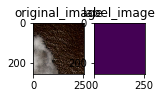

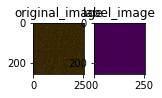

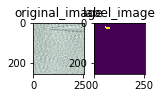

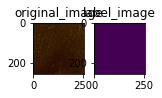

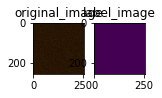

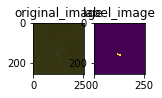

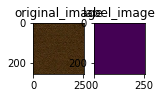

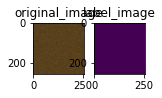

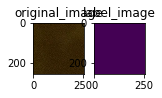

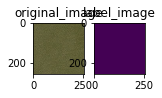

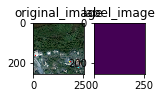

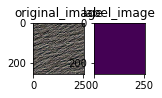

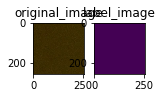

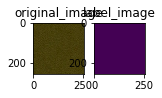

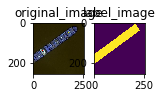

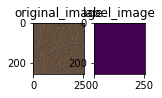

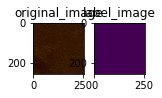

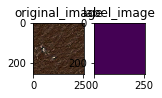

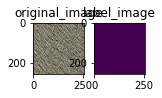

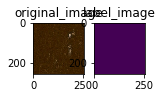

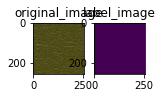

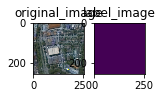

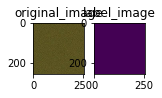

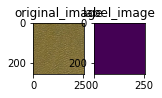

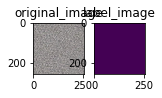

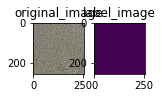

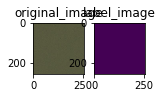

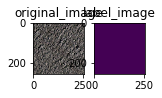

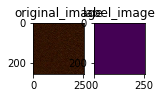

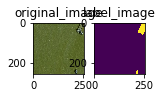

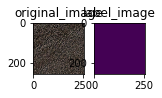

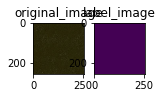

In [22]:
n = 0 
for _,(images,img_masks) in enumerate(train_batch):
    x = Variable(images).cuda(0)
    y_ = Variable(img_masks.mean(dim=1,keepdim=True)).cuda(0).cpu()
    for k in range(16):
        plt.figure(figsize=(2,3))
        plt.subplot(121)
        plt.imshow(np.array(x.cpu().data[k] *256,dtype=np.uint8).transpose()) 
        plt.title("original_image")
        plt.subplot(122)
        plt.imshow(np.array(y_.cpu().data[k]).mean(axis=0).transpose()) 
        plt.title("label_image") 
        plt.show()
        
    n += 1 
    if n >= 2:
        break

In [23]:
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1 import make_axes_locatable
cdict3 = {'red':((0.0,1.0,1.0),
                 (0.5,0.25,0.25),
                 (1.0,1.0,1.0)),
          'green':((0.0,1.0,1.0),
                   (0.5,0.5,0.5),
                   (0.75,1.0,1.0),
                   (1.0,0.25,0.25)),
          'blue':((0.0,1.0,1.0),
                  (0.5,0.75,0.75),
                  (0.75,0.0,0.0),
                  (1.0,0.0,0.0))}
cmap = clr.LinearSegmentedColormap('cmap', cdict3)


In [24]:
%matplotlib auto

Using matplotlib backend: TkAgg


In [27]:
m = m.cuda(0)
epoch = 4
def train(epoch, lr, folder, stopping=9999):
    if not folder in os.listdir("."):
        os.mkdir(folder) 
    lrs = np.array([lr/100, lr/10, lr]) 
    gen_optimizer = torch.optim.Adam(m.parameters(),lr=lr)
    file = open('./unet_loss_0.002', 'w')
    loss_record = []
    last_valid_loss = 999999
    for i in range(epoch):
        if i >= 1:
            gen_optimizer = torch.optim.Adam(m.parameters(), lr=lrs[i%3])
        if i == 1:
            for param in m.parameters():
                param.requires_grad = True
        for _, (images,img_masks) in enumerate(train_batch):
            gen_optimizer.zero_grad()

            x = Variable(images.float()).cuda(0)
            y_ = Variable(img_masks.mean(dim=1,keepdim=True)).cuda(0)
            y = m.forward(x).reshape(-1, 1, img_size, img_size).cuda(0) 

            loss = loss_func(y,y_)
            file.write(str(loss.data[0])+"\n")
            loss_record.append(loss.data[0])
            loss.backward()
            gen_optimizer.step()


            if _ % 400 ==0:
                print("epoch : {}, time : {}, loss : {}".format(i, _, loss.data[0]))
                plt.figure()
                plt.title("original")
                for img_num in range(20):
                    plt.subplot(4,5,img_num+1)
                    plt.imshow(np.array(x.cpu().data[img_num]*256,dtype=np.uint8).transpose())
                    plt.tick_params(labelbottom='off',bottom='off')
                    plt.tick_params(labelleft='off', left='off')
                plt.savefig(folder + "/{}_{}_{}.png".format(i,_,"original"))

                plt.figure()
                plt.title('label') 
                for img_num in range(20):
                    plt.subplot(4,5,img_num+1)
                    plt.imshow(np.array(y_.cpu().data[img_num]).mean(axis=0).transpose())
                    plt.tick_params(labelbottom='off',bottom='off')
                    plt.tick_params(labelleft='off', left='off')
                plt.savefig(folder + "/{}_{}_{}.png".format(i,_,"label"))


                plt.figure()
                plt.title('generated')
                for img_num in range(20):
                    plt.subplot(4,5,img_num+1)
                    a = np.array(y.cpu().data[0]).transpose().reshape(256,256)
                    ax = plt.gca()
                    im = ax.imshow(a, cmap=cmap,vmin=-1,vmax=1) 

                    plt.tick_params(labelbottom='off',bottom='off')
                    plt.tick_params(labelleft='off', left='off')
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
                plt.savefig(folder + "/{}_{}_{}.png".format(i,_,"generated"))

                torch.save(m.state_dict(), folder + '/u_net_{}_{}.pkl'.format(i,_))  
                if _ != 0  and _ != 3000:
                    os.remove(last_file_path)

                last_file_path =  folder + '/u_net_{}_{}.pkl'.format(i,_)
            if _ % 2000 == 0 or _==400 or _ == stopping:
                plt.figure(figsize=(7,7)) 
                plt.plot(np.convolve(loss_record, v = np.ones(100)/100.0))
                plt.xlabel("num_batch") 
                plt.ylabel("train_loss")
                plt.yscale('log')
                plt.title("Loss")
                plt.savefig(folder + "/{}_{}_{}.png".format(i,_,"loss"))
                loss_list = [] 
                for k, (images, img_masks) in enumerate(valid_batch):
                    x = Variable(images).cuda(0)
                    y_ = Variable(img_masks.mean(dim=1,keepdim=True)).cuda(0)
                    y = m.forward(x).reshape(-1, 1, img_size, img_size)
                    loss_list.append(loss_func(y,y_).data[0]) 

                valid_loss = np.array(loss_list).mean() 
                print("Epoch :{}, Time : {} , Valid_Loss: {}".format(i, _,valid_loss))
                if _ == 0 and last_valid_loss < valid_loss:
                    lr /= 5
                    gen_optimizer = torch.optim.Adam(m.parameters(),lr=lr)
                    print("the learning rate turned to be  ", lr)
                if _ == 0:
                    last_valid_loss = valid_loss
            
            if _ > stopping:
                break

            del x
            del y_
            del y
            gc.collect();

Now learning rate is  0.1 



C:\Users\sunhe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\sunhe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\sunhe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0, time : 0, loss : 6.628112316131592


C:\Users\sunhe\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\sunhe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:85: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch :0, Time : 0 , Valid_Loss: 8.340385437011719
epoch : 0, time : 400, loss : 4.382365703582764
Epoch :0, Time : 400 , Valid_Loss: 8.25282096862793
epoch : 0, time : 800, loss : 6.017841339111328
Epoch :0, Time : 1000 , Valid_Loss: 8.259763717651367
Now learning rate is  0.01 

epoch : 0, time : 0, loss : 7.593666076660156
Epoch :0, Time : 0 , Valid_Loss: 9.454449653625488
epoch : 0, time : 400, loss : 13.69255542755127
Epoch :0, Time : 400 , Valid_Loss: 8.305442810058594
epoch : 0, time : 800, loss : 6.120797157287598


C:\Users\sunhe\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch :0, Time : 1000 , Valid_Loss: 8.001070976257324
Now learning rate is  0.001 

epoch : 0, time : 0, loss : 8.352383613586426
Epoch :0, Time : 0 , Valid_Loss: 9.687223434448242
epoch : 0, time : 400, loss : 3.7405104637145996
Epoch :0, Time : 400 , Valid_Loss: 7.5853962898254395
epoch : 0, time : 800, loss : 4.778707504272461
Epoch :0, Time : 1000 , Valid_Loss: 7.557015419006348
Now learning rate is  0.0001 

epoch : 0, time : 0, loss : 7.113821506500244
Epoch :0, Time : 0 , Valid_Loss: 10.061601638793945
epoch : 0, time : 400, loss : 8.988757133483887
Epoch :0, Time : 400 , Valid_Loss: 7.901820182800293
epoch : 0, time : 800, loss : 4.111480712890625
Epoch :0, Time : 1000 , Valid_Loss: 7.610715389251709
Now learning rate is  1e-05 

epoch : 0, time : 0, loss : 6.979061603546143
Epoch :0, Time : 0 , Valid_Loss: 9.660664558410645
epoch : 0, time : 400, loss : 6.077060699462891
Epoch :0, Time : 400 , Valid_Loss: 9.537057876586914
epoch : 0, time : 800, loss : 7.73708963394165
Epoch :

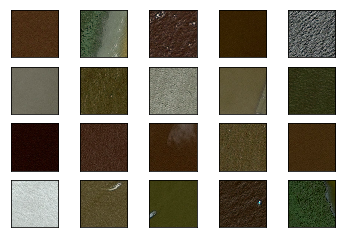

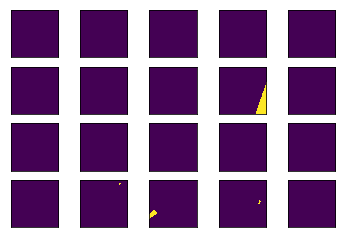

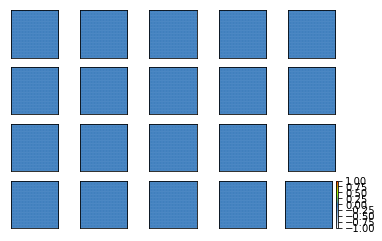

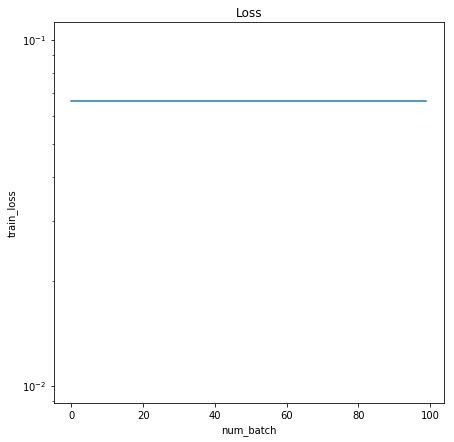

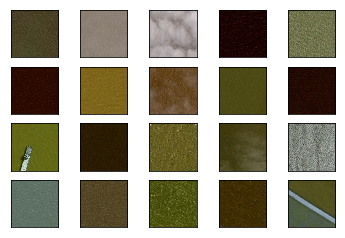

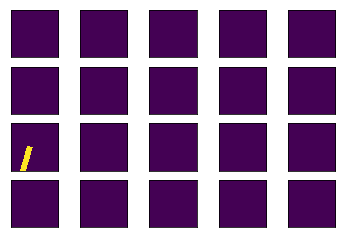

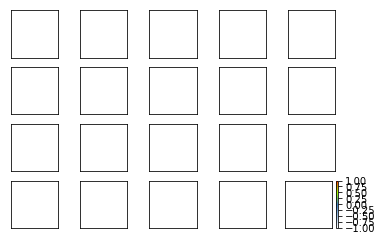

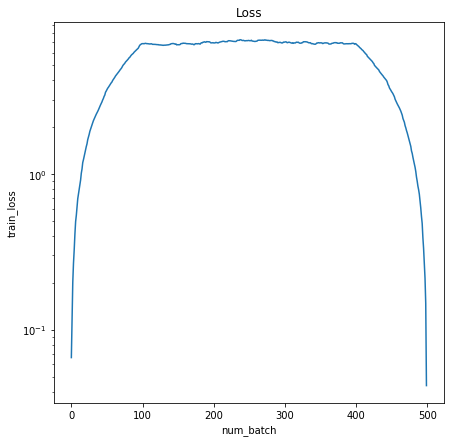

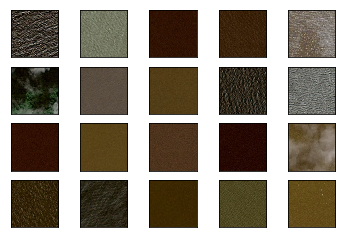

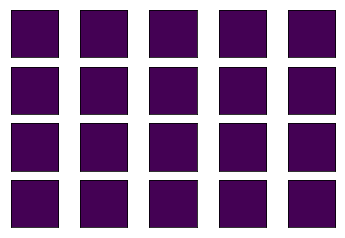

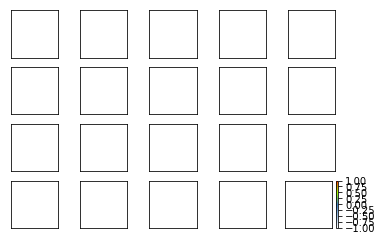

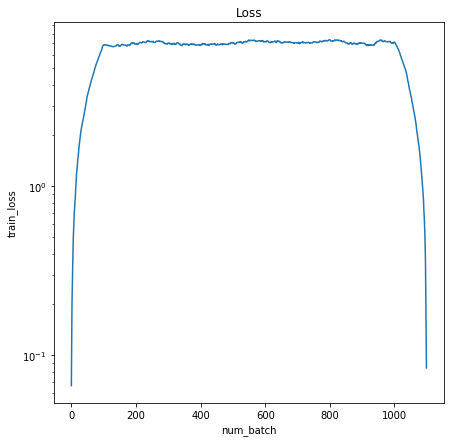

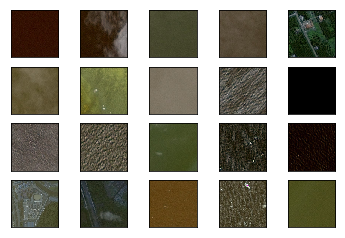

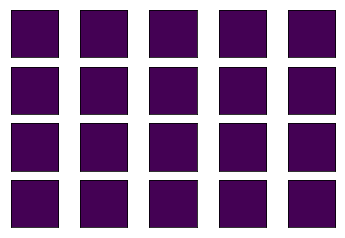

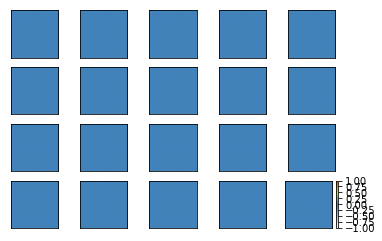

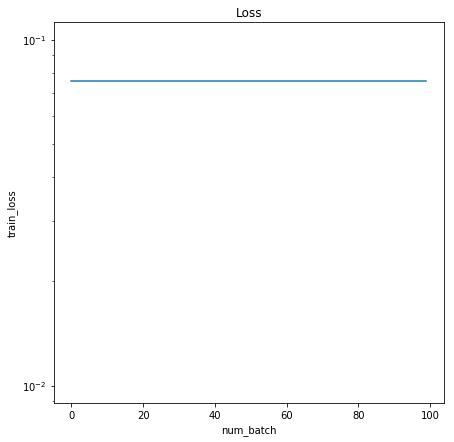

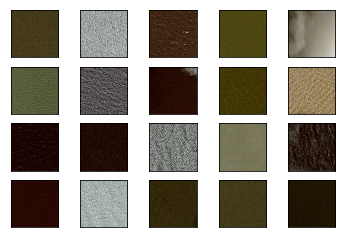

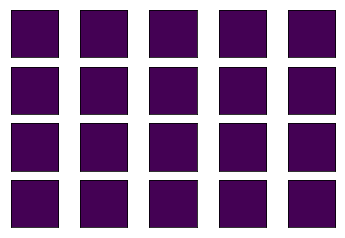

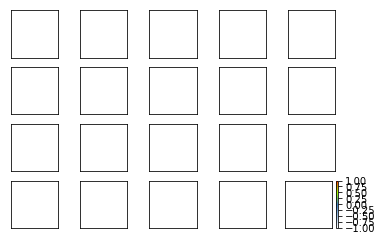

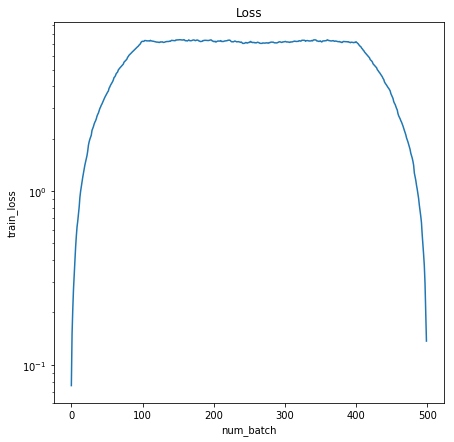

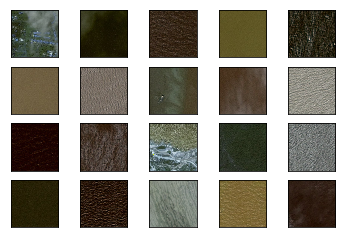

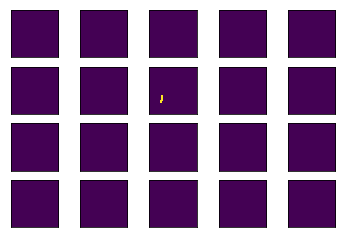

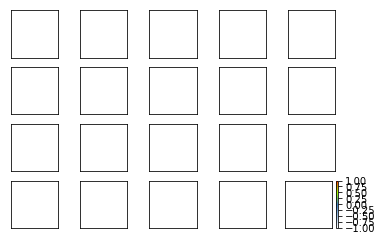

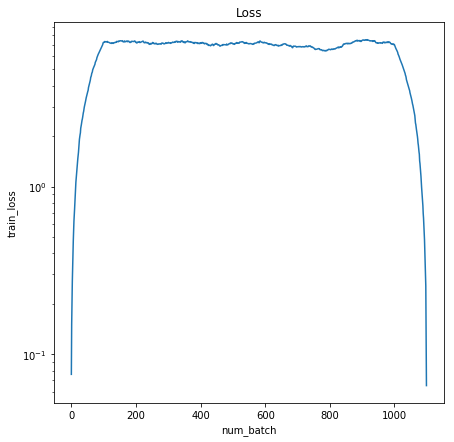

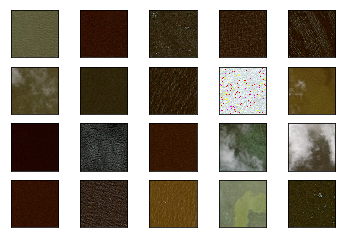

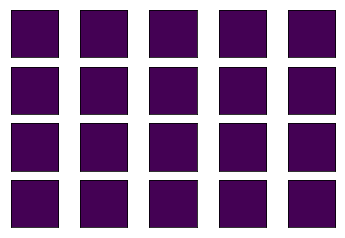

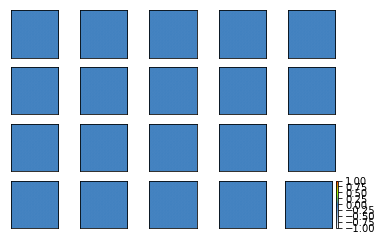

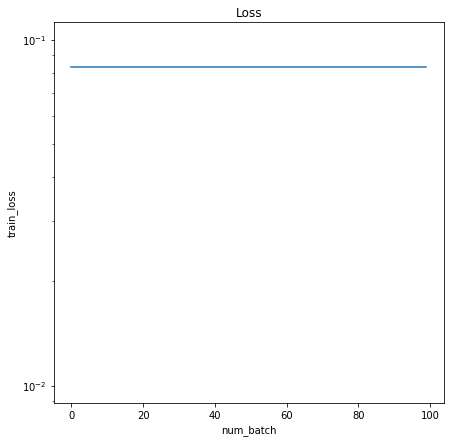

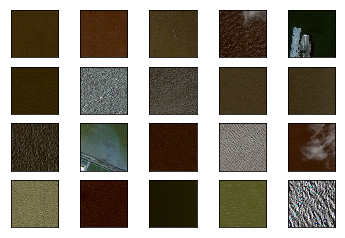

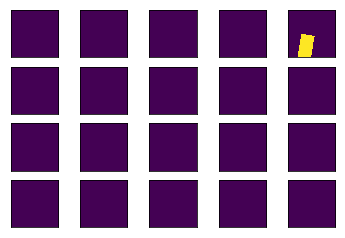

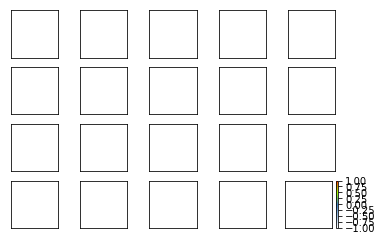

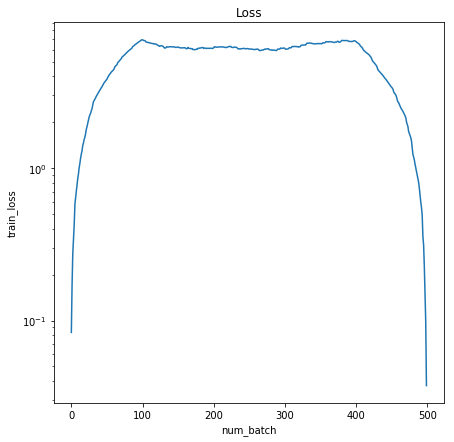

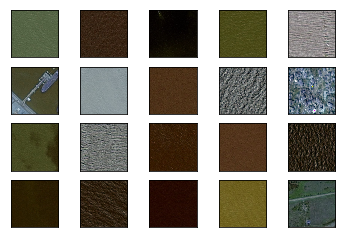

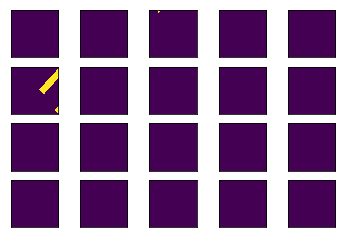

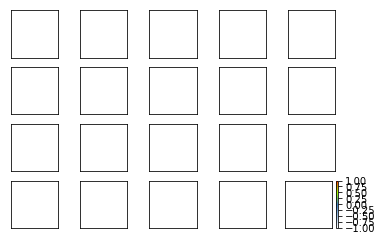

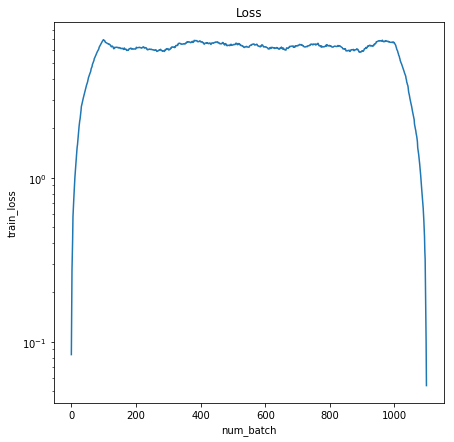

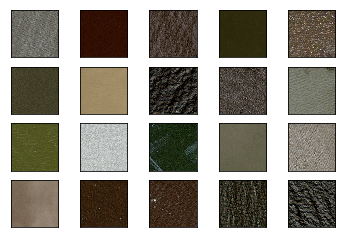

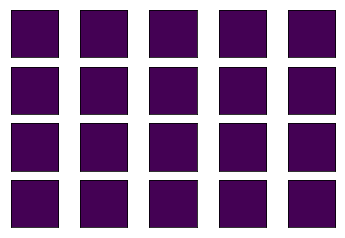

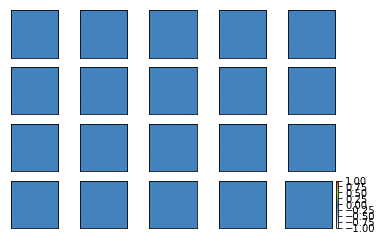

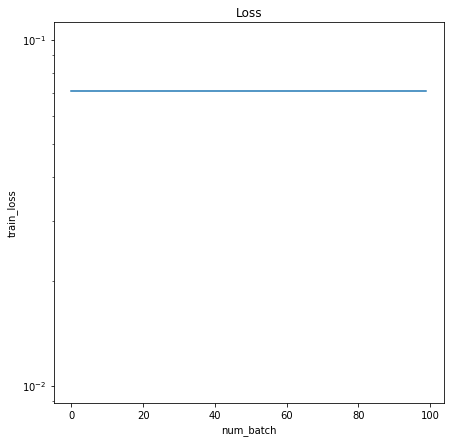

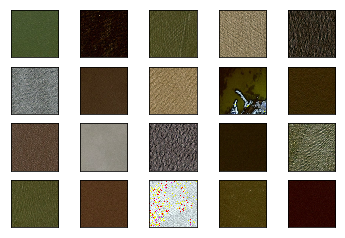

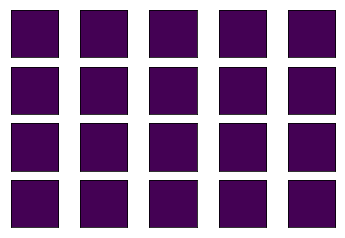

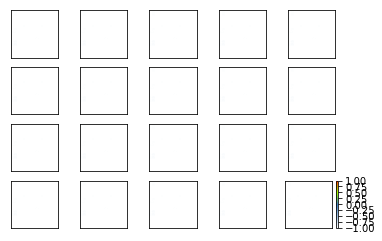

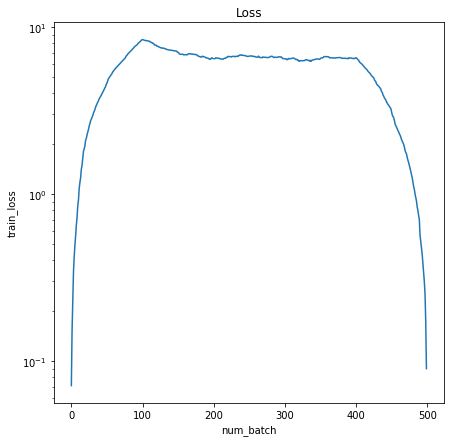

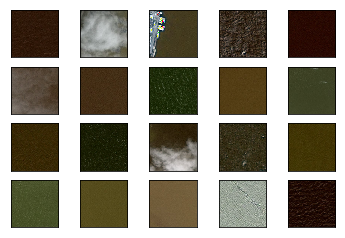

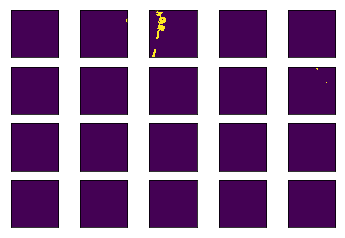

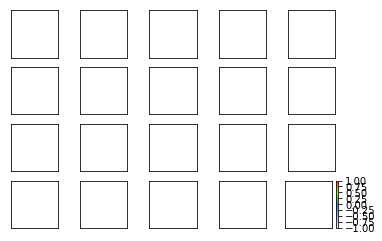

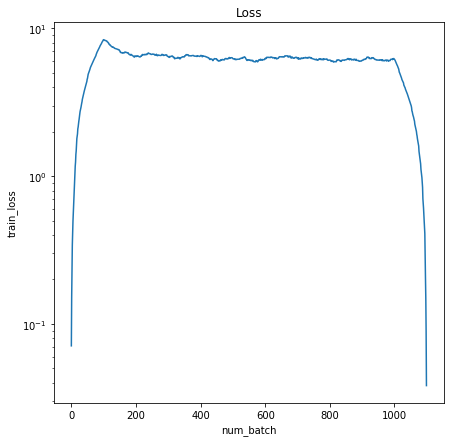

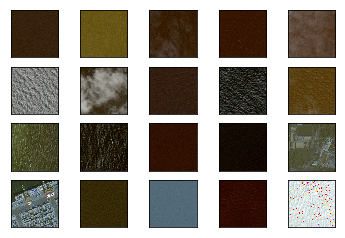

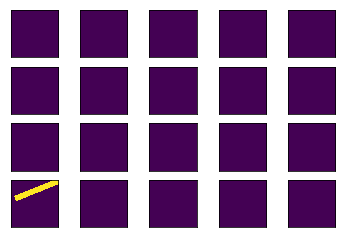

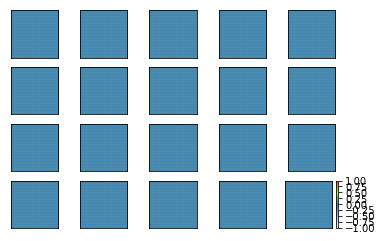

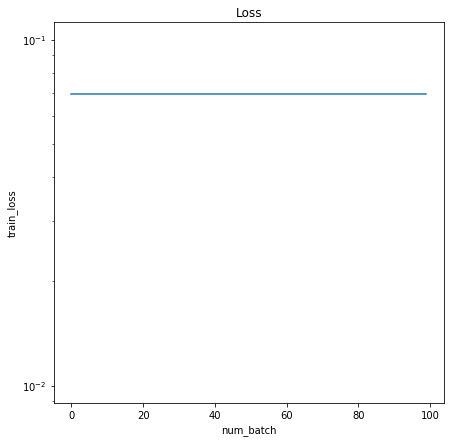

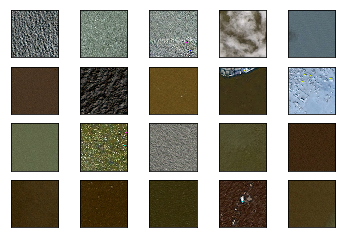

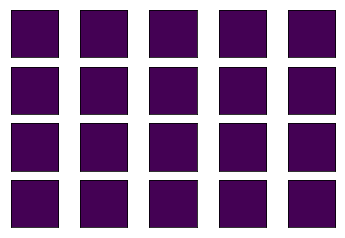

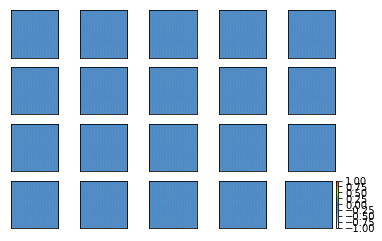

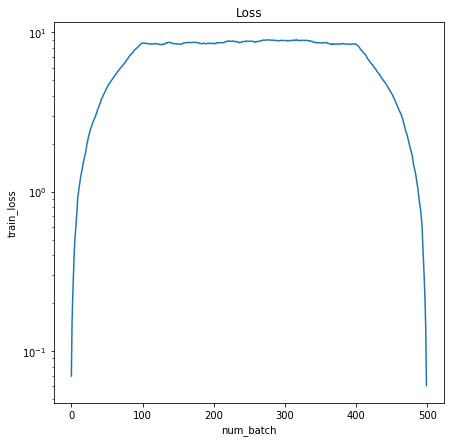

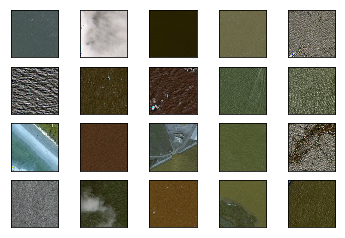

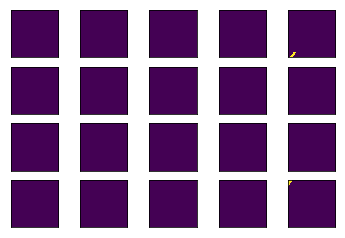

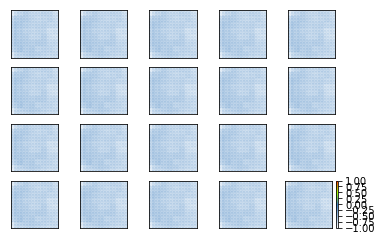

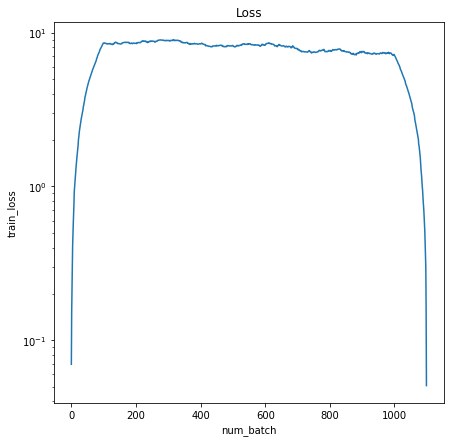

In [29]:
for lr in [0.1,0.01,0.001,0.0001,0.00001]:
    m = make_model()
    m = m.cuda(0) 
    print("Now learning rate is ", lr, "\n")
    train(1, lr, "1001", stopping=1000)